**Executed:** Thu Apr 27 03:12:27 2017

**Duration:** 4 seconds.

**Autogenerated from:** [./inference-template.ipynb](./inference-template.ipynb)

In [1]:
# states for evidence are 0 based
vtx_to_ev = {'WetGrass': 1}
# vtx_to_ev ={}
# default values of file paths, assuming quantum_fog is working dir
in_bif = 'examples_cbnets/WetGrass.bif'
in_dot = 'examples_cbnets/WetGrass.dot'
qfog_path = None

In [2]:
# Cell inserted during automated execution.
vtx_to_ev = {}
in_bif = 'examples_cbnets/WetGrass.bif'
in_dot = 'examples_cbnets/WetGrass.dot'
qfog_path = '/home/jupyter/Notebooks/Quantum/quantum-fog'

**Inference Template**

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Paths-and-Imports" data-toc-modified-id="Paths-and-Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Paths and Imports</a></div><div class="lev1 toc-item"><a href="#Picture-of-Network" data-toc-modified-id="Picture-of-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Picture of Network</a></div><div class="lev1 toc-item"><a href="#Inference-Tests" data-toc-modified-id="Inference-Tests-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Inference Tests</a></div><div class="lev2 toc-item"><a href="#QFog" data-toc-modified-id="QFog-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>QFog</a></div><div class="lev2 toc-item"><a href="#BNT" data-toc-modified-id="BNT-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>BNT</a></div><div class="lev1 toc-item"><a href="#Summary" data-toc-modified-id="Summary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Summary</a></div>

# Paths and Imports

In [3]:
import os
import sys
if not qfog_path:
    os.chdir('../../')
else:
    os.chdir(qfog_path)
cwd = os.getcwd()
sys.path.insert(0,cwd)
print("cwd=", cwd)

cwd= /home/jupyter/Notebooks/Quantum/quantum-fog


In [4]:
bnt_path = '/home/jupyter/Notebooks/Classical/bnt'

In [5]:
import numpy as np
from graphviz import Source
import time

In [6]:
from graphs.BayesNet import *
from inference.JoinTreeEngine import *

In [7]:
# this doesn't work because of hyphen:
# from jupyter-notebooks.nbrun import run_notebook

import importlib
mod = importlib.import_module("jupyter-notebooks.nbrun")

In [8]:
import oct2py
%load_ext oct2py.ipython

In [9]:
%%octave
do_braindead_shortcircuit_evaluation (1)
warning('off', 'Octave:possible-matlab-short-circuit-operator')

In [10]:
%octave_push bnt_path
# genpath(dir) grows dir to list of all files inside it (recursive)
%octave addpath(genpath(bnt_path))  

In [11]:
%run jupyter-notebooks/bnt-examples/bnt-biftool.ipynb

# Picture of Network

In [12]:
from IPython.display import Image, display
def show_dot(dotfile):
    Source(open(dotfile).read(),format ='png').render(view=False);
    display(Image(filename='Source.gv.png'))

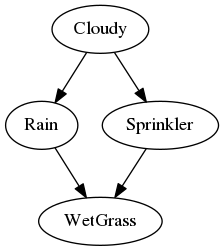

In [13]:
show_dot(in_dot)

# Inference Tests

## QFog

In [14]:
bn_fog = BayesNet.read_bif(in_bif, False)

In [15]:
node_list = list(bn_fog.nodes)
num_nds = len(node_list)

In [16]:
# introduce some evidence
for vtx, k in vtx_to_ev.items():
    bn_fog.get_node_named(vtx).active_states = [k]

In [17]:
%octave tic;
in_time = time.time()

jtree_eng = JoinTreeEngine(bn_fog)
jtree_pot_list = jtree_eng.get_unipot_list(node_list)

# build qfog_to_vtx dict
qfog_vtx_to_pot = {node_list[k].name: jtree_pot_list[k] for k in range(num_nds)}

qfog_elapsed_time = time.time() - in_time
%octave qfog_tictoc = toc;
%octave_pull qfog_tictoc

## BNT

In [18]:
# use function in bnt_biftool.ipynb to load bnet to octave memory
vtx_to_states = bnt_read_bif(in_bif)
vtx_to_states

{'Cloudy': ['state0', 'state1'],
 'Rain': ['state0', 'state1'],
 'Sprinkler': ['state0', 'state1'],
 'WetGrass': ['state0', 'state1']}

In [19]:
#%octave bnet

In [20]:
num_nds = len(vtx_to_states)
%octave_push num_nds

In [21]:
# introduce some evidence
%octave evidence = cell(1, num_nds);
for vtx, ev in vtx_to_ev.items():
    k = vtx_to_ev[vtx] + 1 # values of vtx_to_ev are zero based
    %octave_push vtx k
    %octave evidence{bnet.names(vtx)} = k;

In [22]:
%%octave -o bnt_tictoc,bnt_pots
tic;

engine = jtree_inf_engine(bnet);
[engine, loglik] = enter_evidence(engine, evidence);
bnt_pots = cell(1, num_nds);
for k = 1:num_nds
    marg = marginal_nodes(engine, k);
    bnt_pots{k} = marg.T;
end
    
bnt_tictoc = toc;

In [23]:
print(bnt_pots)

[[array([[ 0.5],
       [ 0.5]]) array([[ 0.45],
       [ 0.55]])
  array([[ 0.45],
       [ 0.55]]) array([[ 0.2207],
       [ 0.7793]])]]


In [24]:
# build bnt_to_vtx in python from bnt_pots in octave
bnt_vtx_to_pot = {}
for vtx in vtx_to_states:
    %octave_push vtx
    %octave k = bnet.names(vtx);
    %octave_pull k
    bnt_vtx_to_pot[vtx] = bnt_pots[0, int(k)-1]

# Summary

In [25]:
%%bash
rm -f  Source.gv Source.gv.png

In [26]:
for vtx in qfog_vtx_to_pot:
    print("--------------pot for " + vtx + "-------------------")
    print("QFog:\n", qfog_vtx_to_pot[vtx])
    print("BNT:\n", bnt_vtx_to_pot[vtx])
    

--------------pot for Sprinkler-------------------
QFog:
 ['Sprinkler']
[ 0.45  0.55]
BNT:
 [[ 0.45]
 [ 0.55]]
--------------pot for Rain-------------------
QFog:
 ['Rain']
[ 0.45  0.55]
BNT:
 [[ 0.45]
 [ 0.55]]
--------------pot for WetGrass-------------------
QFog:
 ['WetGrass']
[ 0.2207  0.7793]
BNT:
 [[ 0.2207]
 [ 0.7793]]
--------------pot for Cloudy-------------------
QFog:
 ['Cloudy']
[ 0.5  0.5]
BNT:
 [[ 0.5]
 [ 0.5]]


In [27]:
print('Elapsed times:')
print("QFog:\n", qfog_elapsed_time, "\n", qfog_tictoc)
print("BNT:\n", bnt_tictoc)

Elapsed times:
QFog:
 0.002905607223510742 
 0.026067018508911133
BNT:
 0.05792403221130371
